In [31]:
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#import tensorflow as tf
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np
from corpora_utils import CorporaHelper,CorporaDomains, CorporaProperties
import os
import pickle

In [32]:
MULTIGENRE = 'muligenre'
TWITTER = 'twitter'
MG_AND_TWITTER = 'mg_and_twitter'

In [33]:
# set wich corpora to use Multigenre or twitter
use_mg_model = MULTIGENRE

use_mg_coprora = MULTIGENRE

tokenizer = None

if use_mg_model == MULTIGENRE:
    model = load_model('models/model_emotion_detection_multigenre.h5')
    tokenizer = pickle.load(open('models/tokenizer_multigenre.pkl', 'rb'))
    print("Use MULTIGENRE model")
    
elif use_mg_model == TWITTER:
    model = load_model('models/model_emotion_detection_twitter.h5')
    tokenizer = pickle.load(open('models/tokenizer_twitter.pkl', 'rb'))
    print("Use TWITTER model")
else:
    model = load_model('models/model_emotion_detection_multigenre_twitter.h5')
    tokenizer = pickle.load(open('models/tokenizer_multigenre_twitter.pkl', 'rb'))
    print("Use TWITTER and MULTIGENRE model")

Use MULTIGENRE model


In [34]:
def load_corpora(filepath, sep=';'):
    print('Load: ', filepath)
    corpora_helper = CorporaHelper(filepath, separator=sep)
    count_joy = 0
    count_sadness = 0
    count_anger = 0
    count_fear = 0
    labels = []
    texts = []
    # preprocessing corpora
    corpora_helper.translate_urls()
    corpora_helper.translate_emoticons()
    corpora_helper.translate_emojis()
    corpora_helper.translate_email()
    #corpora_helper.translate_mention()
    corpora_helper.translate_html_tags()
    #corpora_helper.translate_camel_case()
    corpora_helper.translate_underscore()

    corpora_helper.translate_string('-LRB-','(')
    corpora_helper.translate_string('-RRB-',')')
    corpora_helper.translate_string('`',"'") # ` to '
    corpora_helper.translate_string("''",'"') # double '' to "
    corpora_helper.translate_contractions()
    corpora_helper.translate_string("'","") # remove '
    corpora_helper.translate_string("\\n"," ") # replace new lines with space

    #corpora_helper.spell_correction()
    corpora_helper.add_space_at_special_chars()
    corpora_helper.add_space_at_special_chars(regexlist = r"([#])")
    #corpora_helper.translate_to_lower()

    # 0 anger
    # 1 fear
    # 2 joy
    # 3 sadness
    for index, corpus in corpora_helper.get_data().iterrows():
        if corpus[CorporaProperties.EMOTION.value] == 'anger':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(0)
            count_anger += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'fear':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(1)
            count_fear += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'joy':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(2)
            count_joy += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'sadness':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(3)
            count_sadness += 1
    print('number of anger labels: ',count_anger)
    print('number of fear labels: ', count_fear)
    print('number of joy labels: ', count_joy)
    print('number of sadness labels: ', count_sadness)
    print('----------------------------------------------------------------------')
    return texts, labels
    #max_data = count_anger + count_fear + count_joy + count_sadness

test_file = ""
sep = ';'
word_embeddings_path = ''
if use_mg_coprora == MULTIGENRE:
    test_file = "corpora/multigenre_450_test.csv"
    sep = ';'
    maxlen = 100
    print("Use MULTIGENRE test corpora")
elif use_mg_coprora == TWITTER:
    test_file = "corpora/twitter_2000_test.csv"
    sep = '\t'
    maxlen = 100
    print("Use TWITTER test corpora")
else:
    test_file = "corpora/twitter_2000_mg_450_test.csv"
    sep = '\t'
    maxlen = 100
    print("Use TWITTER and MULTIGENRE test corpora")

test_texts, test_labels = load_corpora(test_file, sep=sep)


Use MULTIGENRE test corpora
Load:  corpora/multigenre_450_test.csv
number of anger labels:  45
number of fear labels:  45
number of joy labels:  45
number of sadness labels:  45
----------------------------------------------------------------------


In [35]:
# Create train an test data set
def create_data(texts, labels, maxlen):
    ## Create one hot encoding
    #max_words = 10000
    #maxlen = 100 # max. number of words in sequences
    #tokenizer = Tokenizer(num_words=max_words, filters = '')
    #tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_i = tokenizer.word_index
    print ('%s unique Tokens found.' % len(word_i))

    data = pad_sequences(sequences, maxlen=maxlen)

    labels_arr = np.asarray(labels)
    print('Shape of data:', data.shape)
    print('Shape of labels:', labels_arr.shape)
    print('-------------------------------------------')

    # mix the data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels_arr = labels_arr[indices]

    # split in train and validate
    x_data = data
    y_data = labels_arr
    return x_data, y_data

In [36]:
# Test data
#tokenizer.fit_on_texts(test_texts)
x_test, y_test  = create_data(test_texts, test_labels, maxlen)

5140 unique Tokens found.
Shape of data: (180, 100)
Shape of labels: (180,)
-------------------------------------------


In [37]:
# Test final model
print("Evaluate model on test data")
results = model.evaluate(x_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate model on test data
180/180 [==============================] - 0s 2ms/step
test loss, test acc: [0.6164436777432759, 0.7388888597488403]


In [38]:
# Evaluation metrics
y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool, [0,  1, 2, 3],['anger',  'fear', 'joy', 'sadness']))
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_bool)
mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
mean_f1 = np.mean(f1)
print("Precision overall: ", mean_precision)
print("Recall overall: ", mean_recall)
print("F1 overall: ", mean_f1)
print("--------------------------------------")

180/180 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       anger       0.93      0.91      0.92        45
        fear       0.69      0.80      0.74        45
         joy       0.68      0.67      0.67        45
     sadness       0.65      0.58      0.61        45

    accuracy                           0.74       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.74      0.74      0.74       180

Precision overall:  0.7389860139860139
Recall overall:  0.7388888888888889
F1 overall:  0.7373845912742486
--------------------------------------


C:\Users\COMMANDER\.conda\envs\gputest\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3], target_names=['anger', 'fear', 'joy', 'sadness'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


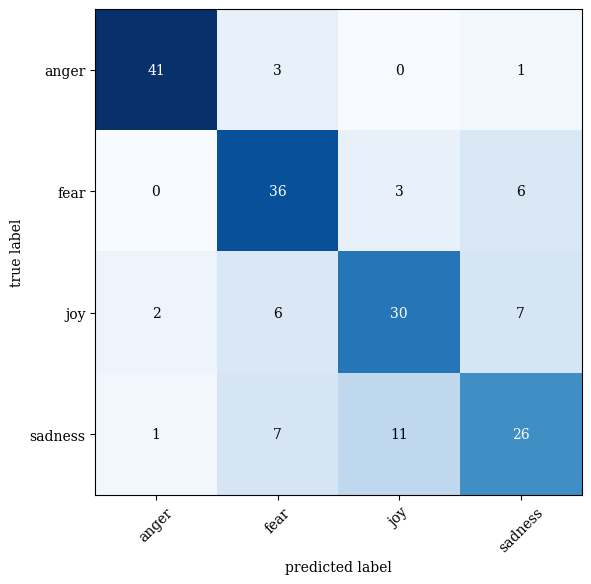

In [39]:
# Create confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib
import matplotlib.pyplot as plt

y_pred = model.predict_classes(x_test)
accuracy_score(y_test, y_pred)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('font', family = 'Serif')

mat = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=mat, figsize=(6,6), class_names = ['anger', 'fear', 'joy', 'sadness'], show_normed=False)
plt.tight_layout()
fig.savefig('MG to ALL CM of fine-tuned BiLSTM-NN-Model.png')
plt.show()
